In [8]:
#pip install ipywidgets
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.1.post1.


In [23]:
pip install --upgrade ipywidgets

   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--:--
   ----------- --------------------------- 41.0/139.4 kB 487.6 kB/s eta 0:00:01
   ---------------------------------------- 139.4/139.4 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/215.0 kB ? eta -:--:--
   ------------------------------------ --- 194.6/215.0 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 215.0/215.0 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.3 MB 9.4 MB/s eta 0:00:01
   --------------- ------------------------ 0.9/2.3 MB 9.5 MB/s eta 0:00:01
   ------------------------- -------------- 1.4/2.3 MB 10.2 MB/s eta 0:00:01
   ---------------------------------- ----- 2.0/2.3 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 10.4 MB/s eta 0:00:00
  Attempting u

In [24]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------------
H2O_cluster_uptime:         3 mins 43 secs
H2O_cluster_timezone:       America/Denver
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    17 days
H2O_cluster_name:           H2O_from_python_avinash_tiwari_e7u7bw
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.841 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.7 final
--------------------------  -------------------------------------

In [25]:
#O:\Lof\creditcard.csv
df = h2o.import_file("O:\Lof\creditcard.csv")

In [26]:
seed = 12345
ntrees = 100
isoforest = h2o.estimators.H2OIsolationForestEstimator(
    ntrees=ntrees, seed=seed)
isoforest.train(x=df.col_names[0:30], training_frame=df)
predictions = isoforest.predict(df)

predictions

predict    mean_length
---------  -------------
0.0188679           6.92
0.0117925           6.95
0.0707547           6.7
0.0448113           6.81
0.0165094           6.93
0.0165094           6.93
0.0165094           6.93
0.0613208           6.74
0.0400943           6.83
0.0117925           6.95
[284807 rows x 2 columns]

In [27]:
predictions.cor()

predict    mean_length
---------  -------------
        1             -1
       -1              1
[2 rows x 2 columns]

In [28]:
quantile = 0.95
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs    predictQuantiles    mean_lengthQuantiles
-------  ------------------  ----------------------
   0.95            0.153302                    6.99
[1 row x 3 columns]

In [29]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = df["Class"]
predictions

predict    mean_length    predicted_class    class
---------  -------------  -----------------  -------
0.0188679           6.92                  0        0
0.0117925           6.95                  0        0
0.0707547           6.7                   0        0
0.0448113           6.81                  0        0
0.0165094           6.93                  0        0
0.0165094           6.93                  0        0
0.0165094           6.93                  0        0
0.0613208           6.74                  0        0
0.0400943           6.83                  0        0
0.0117925           6.95                  0        0
[284807 rows x 4 columns]

O:\Anaconda_newest_setup\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


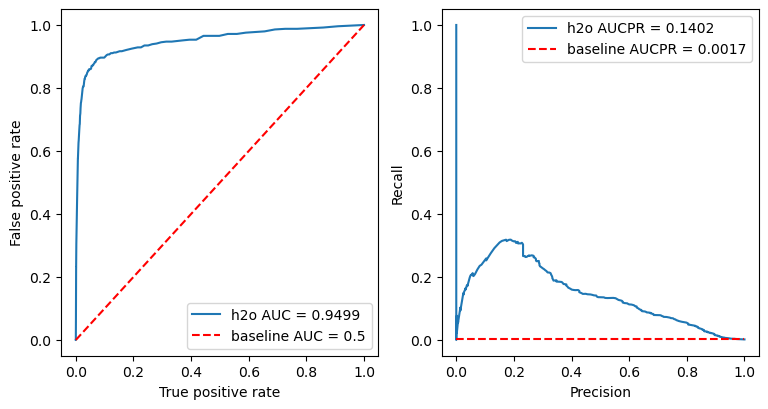

In [30]:
 %matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)


h2o_predictions = predictions.as_data_frame()

figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], "h2o")

In [31]:
 

from sklearn.ensemble import IsolationForest
import pandas as pd

df_pandas = df.as_data_frame()
df_train_pandas = df_pandas.iloc[:, :30]

x = IsolationForest(random_state=seed, contamination=(1-quantile),
                    n_estimators=ntrees).fit(df_train_pandas)

iso_predictions = x.predict(df_train_pandas)
iso_score = x.score_samples(df_train_pandas)

sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "class": h2o_predictions["class"],
    "predict": -iso_score
})

sk_predictions.head()

O:\Anaconda_newest_setup\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


predicted_class  class   predict
0                0      0  0.389996
1                0      0  0.372515
2                0      0  0.470305
3                0      0  0.419148
4                0      0  0.395678

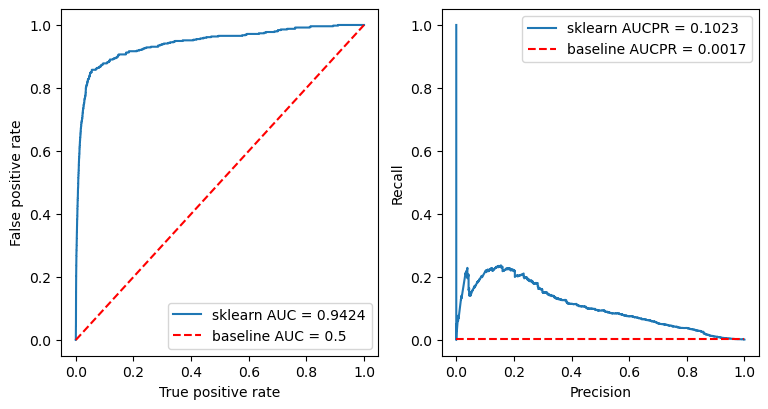

In [32]:
figure()
axes = prediction_summary(
    sk_predictions["class"], sk_predictions["predict"], "sklearn")

In [34]:
from tqdm import tqdm_notebook


def stability_check(train_predict_fn, x, y, ntimes=20):
    scores = ["AUC", "AUCPR"]
    scores = {key: [] for key in scores}
    seeds = np.linspace(1, (2**32) - 1, ntimes).astype(int)
    for seed in tqdm_notebook(seeds):
        predictions = train_predict_fn(x, int(seed))
        _, _, auc_score = get_auc(y, predictions)
        _, _, aucpr_score = get_aucpr(y, predictions)

        scores["AUC"].append(auc_score)
        scores["AUCPR"].append(aucpr_score)

    return pd.DataFrame(scores)


def iso_forests_h2o(data, seed):
    isoforest = h2o.estimators.H2OIsolationForestEstimator(
        ntrees=ntrees, seed=seed)
    isoforest.train(x=data.col_names, training_frame=data)
    preds = isoforest.predict(data)
    return preds.as_data_frame()["predict"]


def iso_forests_sklearn(data, seed):
    iso = IsolationForest(random_state=seed, n_estimators=ntrees,
                           contamination=(1-quantile))
    iso.fit(data)
    iso_score = iso.score_samples(data)
    return -iso_score


h2o.no_progress()

h2o_check = stability_check(iso_forests_h2o, df[:30], h2o_predictions["class"])
sklearn_check = stability_check(
    iso_forests_sklearn, df_train_pandas, sk_predictions["class"])

sklearn_check.join(h2o_check, rsuffix="_h2o", lsuffix="_sklearn").describe()

C:\Users\avinash.tiwari\AppData\Local\Temp\ipykernel_23572\351493786.py:7: RuntimeWarning: invalid value encountered in cast
  seeds = np.linspace(1, (2**32) - 1, ntimes).astype(int)
C:\Users\avinash.tiwari\AppData\Local\Temp\ipykernel_23572\351493786.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm_notebook(seeds):


  0%|          | 0/20 [00:00<?, ?it/s]

O:\Anaconda_newest_setup\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
O:\Anaconda_newest_setup\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting

  0%|          | 0/20 [00:00<?, ?it/s]

InvalidParameterError: The 'random_state' parameter of IsolationForest must be an int in the range [0, 4294967295], an instance of 'numpy.random.mtrand.RandomState' or None. Got -2147483648 instead.